# Classification Models for predicting Departure Delay
This notebook trains the below mentioned models.


1. Linear model(stochastic gradient descent (SGD) Classifier)
2. Linear model(Logistic regression)
3. Tree Based(Decision Tree Classifier)
4. Ensemble model(Random Forest Classifier)
5. Ensemble model(Gradient Boosting Classifier)
6. Naive_bayes model( GaussianNB model)






In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection
from sklearn.metrics import roc_curve 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Data Preprocessing

In [ ]:

df_flight = pd.read_csv("/content/drive/Shareddrives/255 Team Project/Flight Delay Dataset/flights.csv")
df_air = pd.read_csv('/content/drive/Shareddrives/255 Team Project/Flight Delay Dataset/airports.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


df_flight is a huge data, Taking this into consideration, Extracting the data for one month i.e. January Month 

In [ ]:
df_flight = df_flight[df_flight['MONTH'] == 1]

In [ ]:
df_flight.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_air.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


The most important column is the DEPARTURE_DELAY and column CANCELLED is also important considering the fact that when flights gets cancelled, there will be no delay . So, we take values in which flights are not cancelled.

In [ ]:
df_flight.groupby('CANCELLED').size()

CANCELLED
0    457986
1     11982
dtype: int64

In [ ]:
df_flight = df_flight.loc[df_flight.CANCELLED.isin([0])]

Setting DEPARTURE_DELAY as the target value and setting it to 1 when the delay is 0 or greater than 0. otherwise, 0.

In [ ]:
df_flight['DEPARTURE_DELAY'] = (df_flight.DEPARTURE_DELAY > 0).astype('int') 

## Feature Engineering

### Dealing with Numerical features 

In [ ]:
col_with_numerical_values = ['SCHEDULED_TIME','SCHEDULED_ARRIVAL','SCHEDULED_DEPARTURE','DAY_OF_WEEK']


In [ ]:
df_flight[col_with_numerical_values].isnull().sum()

SCHEDULED_TIME         0
SCHEDULED_ARRIVAL      0
SCHEDULED_DEPARTURE    0
DAY_OF_WEEK            0
dtype: int64

### Dealing with categorical features

In [ ]:
col_with_categorical_values = ['AIRLINE','ORIGIN_AIRPORT']


In [ ]:
df_flight[col_with_categorical_values].isnull().sum()

AIRLINE           0
ORIGIN_AIRPORT    0
dtype: int64

One-hot encoding: We create a new feature for each unique value of the column , sets value to 1 if it is unique otherwise,0 using get_dummies function.

In [ ]:
categorical_df = pd.get_dummies(df_flight[col_with_categorical_values],drop_first = True)

In [ ]:
categorical_df.head()

,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,ORIGIN_AIRPORT_ABR,ORIGIN_AIRPORT_ABY,ORIGIN_AIRPORT_ACT,ORIGIN_AIRPORT_ACV,ORIGIN_AIRPORT_ACY,ORIGIN_AIRPORT_ADK,ORIGIN_AIRPORT_ADQ,ORIGIN_AIRPORT_AEX,ORIGIN_AIRPORT_AGS,ORIGIN_AIRPORT_ALB,ORIGIN_AIRPORT_ALO,ORIGIN_AIRPORT_AMA,ORIGIN_AIRPORT_ANC,ORIGIN_AIRPORT_APN,ORIGIN_AIRPORT_ASE,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_ATW,ORIGIN_AIRPORT_AUS,ORIGIN_AIRPORT_AVL,ORIGIN_AIRPORT_AVP,ORIGIN_AIRPORT_AZO,ORIGIN_AIRPORT_BDL,ORIGIN_AIRPORT_BET,ORIGIN_AIRPORT_BFL,ORIGIN_AIRPORT_BHM,...,ORIGIN_AIRPORT_SHV,ORIGIN_AIRPORT_SIT,ORIGIN_AIRPORT_SJC,ORIGIN_AIRPORT_SJT,ORIGIN_AIRPORT_SJU,ORIGIN_AIRPORT_SLC,ORIGIN_AIRPORT_SMF,ORIGIN_AIRPORT_SMX,ORIGIN_AIRPORT_SNA,ORIGIN_AIRPORT_SPI,ORIGIN_AIRPORT_SPS,ORIGIN_AIRPORT_SRQ,ORIGIN_AIRPORT_STC,ORIGIN_AIRPORT_STL,ORIGIN_AIRPORT_STT,ORIGIN_AIRPORT_STX,ORIGIN_AIRPORT_SUN,ORIGIN_AIRPORT_SUX,ORIGIN_AIRPORT_SWF,ORIGIN_AIRPORT_SYR,ORIGIN_AIRPORT_TLH,ORIGIN_AIRPORT_TOL,ORIGIN_AIRPORT_TPA,ORIGIN_AIRPORT_TRI,ORIGIN_AIRPORT_TTN,ORIGIN_AIRPORT_TUL,ORIGIN_AIRPORT_TUS,ORIGIN_AIRPORT_TVC,ORIGIN_AIRPORT_TWF,ORIGIN_AIRPORT_TXK,ORIGIN_AIRPORT_TYR,ORIGIN_AIRPORT_TYS,ORIGIN_AIRPORT_UST,ORIGIN_AIRPORT_VEL,ORIGIN_AIRPORT_VLD,ORIGIN_AIRPORT_VPS,ORIGIN_AIRPORT_WRG,ORIGIN_AIRPORT_XNA,ORIGIN_AIRPORT_YAK,ORIGIN_AIRPORT_YUM
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Adding the categorical dataframe to the Numerical dataframe to include the categorical data.

In [ ]:
df_flight = pd.concat([df_flight,categorical_df], axis = 1)

In [ ]:
input_parameters = col_with_numerical_values + list(categorical_df.columns)
df_complete_data = df_flight[input_parameters + ['DEPARTURE_DELAY']]
df_complete_data.head()

,SCHEDULED_TIME,SCHEDULED_ARRIVAL,SCHEDULED_DEPARTURE,DAY_OF_WEEK,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,ORIGIN_AIRPORT_ABR,ORIGIN_AIRPORT_ABY,ORIGIN_AIRPORT_ACT,ORIGIN_AIRPORT_ACV,ORIGIN_AIRPORT_ACY,ORIGIN_AIRPORT_ADK,ORIGIN_AIRPORT_ADQ,ORIGIN_AIRPORT_AEX,ORIGIN_AIRPORT_AGS,ORIGIN_AIRPORT_ALB,ORIGIN_AIRPORT_ALO,ORIGIN_AIRPORT_AMA,ORIGIN_AIRPORT_ANC,ORIGIN_AIRPORT_APN,ORIGIN_AIRPORT_ASE,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_ATW,ORIGIN_AIRPORT_AUS,ORIGIN_AIRPORT_AVL,ORIGIN_AIRPORT_AVP,ORIGIN_AIRPORT_AZO,...,ORIGIN_AIRPORT_SIT,ORIGIN_AIRPORT_SJC,ORIGIN_AIRPORT_SJT,ORIGIN_AIRPORT_SJU,ORIGIN_AIRPORT_SLC,ORIGIN_AIRPORT_SMF,ORIGIN_AIRPORT_SMX,ORIGIN_AIRPORT_SNA,ORIGIN_AIRPORT_SPI,ORIGIN_AIRPORT_SPS,ORIGIN_AIRPORT_SRQ,ORIGIN_AIRPORT_STC,ORIGIN_AIRPORT_STL,ORIGIN_AIRPORT_STT,ORIGIN_AIRPORT_STX,ORIGIN_AIRPORT_SUN,ORIGIN_AIRPORT_SUX,ORIGIN_AIRPORT_SWF,ORIGIN_AIRPORT_SYR,ORIGIN_AIRPORT_TLH,ORIGIN_AIRPORT_TOL,ORIGIN_AIRPORT_TPA,ORIGIN_AIRPORT_TRI,ORIGIN_AIRPORT_TTN,ORIGIN_AIRPORT_TUL,ORIGIN_AIRPORT_TUS,ORIGIN_AIRPORT_TVC,ORIGIN_AIRPORT_TWF,ORIGIN_AIRPORT_TXK,ORIGIN_AIRPORT_TYR,ORIGIN_AIRPORT_TYS,ORIGIN_AIRPORT_UST,ORIGIN_AIRPORT_VEL,ORIGIN_AIRPORT_VLD,ORIGIN_AIRPORT_VPS,ORIGIN_AIRPORT_WRG,ORIGIN_AIRPORT_XNA,ORIGIN_AIRPORT_YAK,ORIGIN_AIRPORT_YUM,DEPARTURE_DELAY
0,205.0,430,5,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,280.0,750,10,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,286.0,806,20,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,285.0,805,20,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,235.0,320,25,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train-Validation-Test Data Split:
Keeping 60% data for training and 20% for validation and 20% for testing

In [ ]:
total_number_of_samples = len(df_complete_data)
print(total_number_of_samples)

457986


In [ ]:
df_complete_data = df_complete_data.sample(total_number_of_samples)
df_complete_data = df_complete_data.reset_index(drop = True)

In [ ]:
df_for_validation_testing=df_complete_data.sample(frac=0.30)


In [ ]:
df_test = df_for_validation_testing.sample(frac = 0.5)
df_valid = df_for_validation_testing.drop(df_test.index)

In [ ]:
df_train=df_complete_data.drop(df_for_validation_testing.index)

In [ ]:
X_train = df_train[input_parameters].values
X_valid = df_valid[input_parameters].values

y_train = df_train['DEPARTURE_DELAY'].values
y_valid = df_valid['DEPARTURE_DELAY'].values

X_test = df_test[input_parameters].values
y_test = df_test['DEPARTURE_DELAY'].values




print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training shapes: (246382, 328) (246382,)
Validation shapes: (68698, 328) (68698,)


Scaling the data matrices using standat=rd scaler

In [ ]:
scaler  = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_valid_sc = scaler.transform(X_valid)
X_test_sc = scaler.transform(X_test)

In [ ]:
threshold_value = 0.5

# Applying Machine Learning Algorithms

## Logistic Regression model

### fit the model and predict

In [ ]:
model1=LogisticRegression()
model1.fit(X_train_sc, y_train)
y_valid_preds = model1.predict_proba(X_valid_sc)[:,1]

In [ ]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.641
precision on validation data:0.579 
recall on validation data:0.286 
f1 on validation data: 0.383
AUC on validation data: 0.654


In [ ]:
y_test_preds = model1.predict_proba(X_test_sc)[:,1]

In [ ]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.644
precision on test data:0.575 
recall on test data:0.293 
f1 on test data: 0.389
AUC on test data: 0.652


### Plot ROC curve

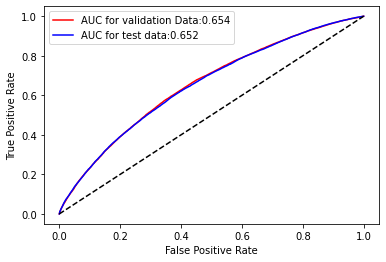

In [ ]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Decision Tree Classifier

### fit the model and predict

In [ ]:
model2 = DecisionTreeClassifier(max_depth=10)
model2.fit(X_train_sc, y_train)
y_valid_preds = model2.predict_proba(X_valid_sc)[:,1]


In [ ]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.650
precision on validation data:0.585 
recall on validation data:0.348 
f1 on validation data: 0.436
AUC on validation data: 0.664


In [ ]:
y_test_preds = model2.predict_proba(X_test_sc)[:,1]

In [ ]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.653
precision on test data:0.583 
recall on test data:0.349 
f1 on test data: 0.437
AUC on test data: 0.665


### Plot ROC curve

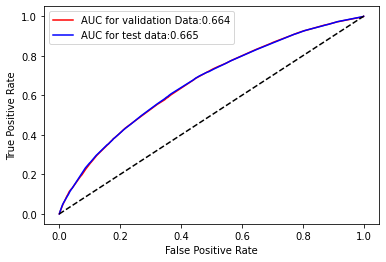

In [ ]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Gaussian Naive Bayes

### fit the model and predict

In [ ]:
model3 = GaussianNB()
model3.fit(X_train_sc, y_train)
y_valid_preds = model3.predict_proba(X_valid_sc)[:,1]


In [ ]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.440
precision on validation data:0.403 
recall on validation data:0.907 
f1 on validation data: 0.558
AUC on validation data: 0.534


In [ ]:
y_test_preds = model3.predict_proba(X_test_sc)[:,1]

In [ ]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.436
precision on test data:0.398 
recall on test data:0.907 
f1 on test data: 0.553
AUC on test data: 0.532


### Plot ROC curve

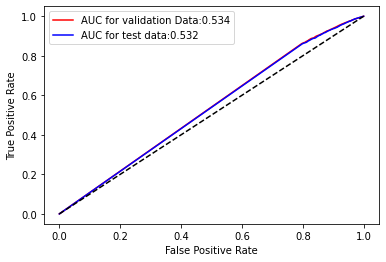

In [ ]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## SGDClassifier

### fit the model and predict

In [ ]:
model4=SGDClassifier(loss = 'log',alpha = 0.1)
model4.fit(X_train_sc, y_train)
y_valid_preds = model4.predict_proba(X_valid_sc)[:,1]

In [ ]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.639
precision on validation data:0.605 
recall on validation data:0.207 
f1 on validation data: 0.308
AUC on validation data: 0.654


In [ ]:
y_test_preds = model4.predict_proba(X_test_sc)[:,1]

In [ ]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.641
precision on test data:0.598 
recall on test data:0.211 
f1 on test data: 0.312
AUC on test data: 0.651


### Plot ROC curve

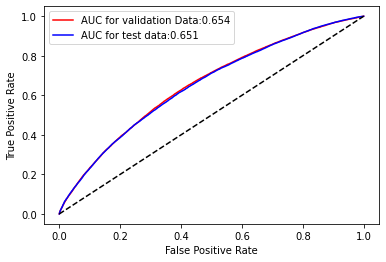

In [ ]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Random Forest Classifier

### fit the model and predict

In [ ]:
model5=RandomForestClassifier(max_depth = 6)
model5.fit(X_train_sc, y_train)
y_valid_preds = model5.predict_proba(X_valid_sc)[:,1]

In [ ]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.614
precision on validation data:0.778 
recall on validation data:0.013 
f1 on validation data: 0.025
AUC on validation data: 0.662


In [ ]:
y_test_preds = model5.predict_proba(X_test_sc)[:,1]

In [ ]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.618
precision on test data:0.774 
recall on test data:0.014 
f1 on test data: 0.028
AUC on test data: 0.662


### Plot ROC curve

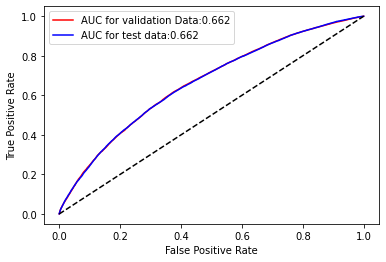

In [ ]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Gradient Boosting Classifier

### fit the model and predict

In [ ]:
model6 =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)
model6.fit(X_train_sc, y_train)
y_valid_preds = model6.predict_proba(X_valid_sc)[:,1]

In [ ]:
print('accuracy on validation data:%.3f'%accuracy_score(y_valid, (y_valid_preds > threshold_value)) )
print("precision on validation data:%.3f "%precision_score(y_valid, (y_valid_preds > threshold_value)) )
print("recall on validation data:%.3f "%recall_score(y_valid, (y_valid_preds > threshold_value)) )
print("f1 on validation data: %.3f"%f1_score(y_valid, (y_valid_preds > threshold_value)) )
print("AUC on validation data: %.3f"%roc_auc_score(y_valid, y_valid_preds ) )

accuracy on validation data:0.656
precision on validation data:0.595 
recall on validation data:0.368 
f1 on validation data: 0.454
AUC on validation data: 0.682


In [ ]:
y_test_preds = model6.predict_proba(X_test_sc)[:,1]

In [ ]:
print('accuracy on test data:%.3f'%accuracy_score(y_test, (y_test_preds > threshold_value)) )
print("precision on test data:%.3f "%precision_score(y_test, (y_test_preds > threshold_value)) )
print("recall on test data:%.3f "%recall_score(y_test, (y_test_preds > threshold_value)) )
print("f1 on test data: %.3f"%f1_score(y_test, (y_test_preds > threshold_value)) )
print("AUC on test data: %.3f"%roc_auc_score(y_test, y_test_preds ) )

accuracy on test data:0.661
precision on test data:0.596 
recall on test data:0.373 
f1 on test data: 0.459
AUC on test data: 0.682


### Plot ROC curve

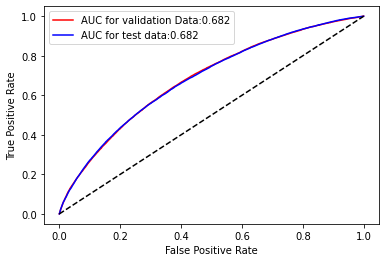

In [ ]:
from sklearn.metrics import roc_curve 

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_valid, tpr_valid, 'r-',label ='AUC for validation Data:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'b-',label ='AUC for test data:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# References
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
